In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from ds_creation.ds_utility import get_file_count, get_other_class
from prototypical.model.loader import load_and_preprocess_image, embedding
from CNN.loader import get_test, get_split
from ds_creation.plot_utility import confusion_matrix_plot
from tqdm import tqdm
import contextlib
import io
from prototypical.model.prototypical import calc_euclidian_dists


MODELS_METRICS_DIR = os.path.join("models_metrics", '31-10_training')
CNN_MODEL_DIR = os.path.join(MODELS_METRICS_DIR, "13_final_model.keras")
PROTO_MODEL_DIR = os.path.join('data_cache', 'proto', 'test_mammals_calls.keras')
SPLIT_DIR = os.path.join("data", "mammals_calls", "splits", "custom")
DATA_DIR = os.path.join("data", "mammals_calls_test")
CNN_PREDICT = False
PROTO_PREDICT = False

species = get_file_count(DATA_DIR)


2025-11-01 15:16:15.599010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-01 15:16:15.671724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-01 15:16:16.741189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# in other_species_list devono finire tutte le classi utilizzate solo dalla prototypical
# queste classi sono contenute nei file di testo che indicano lo split da utilizzare per 
# il train/test della prototypical. Il complementare di queste classi deve essere classificato dalla CNN

other_species_list = []
for file in os.listdir(SPLIT_DIR):
    if file.endswith(".txt"):
        with open(os.path.join(SPLIT_DIR, file), 'r') as f:
            lines = f.readlines()
            other_species_list.extend([line.strip() for line in lines])

# creation of the other directory
other_dict = get_other_class(DATA_DIR, other_species_list)

# dataframe with filenames, labels and an other boolean flag for the other class
other_df = pd.DataFrame((other_dict.items()), columns=['label', 'filenames'])
other_df = other_df.explode('filenames').reset_index(drop=True)
other_df['filenames'] = other_df.apply(lambda x: os.path.join(DATA_DIR, x['label'], x['filenames']), axis=1)
other_df['other'] = 1
print(other_df.head())

                 label                                          filenames  \
0  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
1  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
2  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
3  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   
4  West_Indian_Manatee  data/mammals_calls_test/West_Indian_Manatee/64...   

   other  
0      1  
1      1  
2      1  
3      1  
4      1  


In [3]:
# list of all species excluding 'other' and those in other_species_list
species = os.listdir(DATA_DIR)
species = [spec for spec in species if spec != 'other' and spec not in other_species_list]
print(len(species), "species found.")
print(len(other_species_list), "'other' species used.")

# dataframe with filenames, labels and an other boolean flag for the non-other classes
species_dict = {}
for spec in species:
    spec_path = os.path.join(DATA_DIR, spec)
    files = os.listdir(spec_path)

    files = [os.path.join(spec_path, f) for f in files]
    species_dict[spec] = files

test_df = pd.DataFrame((species_dict.items()), columns=['label', 'filenames'])
test_df = test_df.explode('filenames').reset_index(drop=True)
test_df['other'] = int(0)

# concatenate the two dataframes
test_df = pd.concat([test_df, other_df], ignore_index=True)
print("Total test samples:", len(test_df))
print(test_df.head())

12 species found.
39 'other' species used.
Total test samples: 17572
          label                                          filenames  other
0  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/72021001-...      0
1  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/72021009-...      0
2  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/7202100A-...      0
3  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/78018002-...      0
4  Bearded_Seal  data/mammals_calls_test/Bearded_Seal/66037003-...      0


In [4]:
w = 397
h = 164
c = 3

tqdm.pandas()

def CNN_test(test_sample, model, mapping):
    image = load_and_preprocess_image(test_sample["filenames"], {'h': h, 'w': w})
    image = tf.expand_dims(image, 0)
    with contextlib.redirect_stdout(io.StringIO()):
        predictions = model.predict(image)
    predicted_index = np.argmax(predictions, axis=1)
    predicted_label = mapping[predicted_index[0]]
    test_sample['CNN_predicted_label'] = predicted_label
    test_sample['CNN_predicted_index'] = int(predicted_index)
    return test_sample

def proto_test(test_sample, emb_ref, mapping):
    image = load_and_preprocess_image(test_sample["filenames"], {'h': h, 'w': w})
    image_list = [image]
    sample_embedding = embedding(image_list, {'w':w, 'h':h, 'c':3}, os.path.join('data_cache', 'proto', 'test_mammals_calls.keras'))

    emb_ref['distance'] = emb_ref['embeddings'].apply(lambda x: tf.reduce_mean(tf.math.pow(sample_embedding - x, 2)))

    class_pred = emb_ref[emb_ref['distance'] == emb_ref['distance'].min()]
    test_sample['proto_predicted_label'] = class_pred['class'].values[0]

    return test_sample


def label_to_index(labels, mapping):
    for key, val in mapping.items():
        if val == labels:
            return key
        if val == 'other':
            other = key
    return other

# Load CNN model and embeddings
cnn_model = tf.keras.models.load_model(CNN_MODEL_DIR)
emb_ref = pd.read_pickle("proto_embeddings.pkl")

# Load mapping from index to label
cnn_mapping = pd.read_csv(os.path.join(MODELS_METRICS_DIR, "label_to_index.csv"))
cnn_mapping = cnn_mapping.set_index('index')['label'].to_dict()

# Add index_label column to test_df
test_df['index_label'] = test_df.apply(lambda x: label_to_index(x['label'], cnn_mapping), axis=1)
test_df['index_label'] = test_df['index_label'].astype(int)

# Add columns for predictions
test_df['CNN_predicted_label'] = ''
test_df['CNN_predicted_index'] = -1

# Get CNN predictions
if CNN_PREDICT:
    cnn_pred_df = test_df.progress_apply(lambda x: CNN_test(x, cnn_model, cnn_mapping), axis=1)
    cnn_pred_df.to_csv("cnn_predictions.csv", index=False)
else:
    cnn_pred_df = pd.read_csv("cnn_predictions.csv")

# Get Prototypical predictions for samples predicted as 'other' by CNN
if PROTO_PREDICT:
    proto_test_df = cnn_pred_df[cnn_pred_df['CNN_predicted_label'] == 'other'].reset_index(drop=True)
    proto_test_df['proto_predicted_label'] = ''
    proto_pred_df = proto_test_df.progress_apply(lambda x: proto_test(x, emb_ref, cnn_mapping), axis=1)
    proto_pred_df.to_csv("proto_predictions.csv", index=False)
else:
    proto_pred_df = pd.read_csv("proto_predictions.csv")


I0000 00:00:1762010178.307479  855862 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16847 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


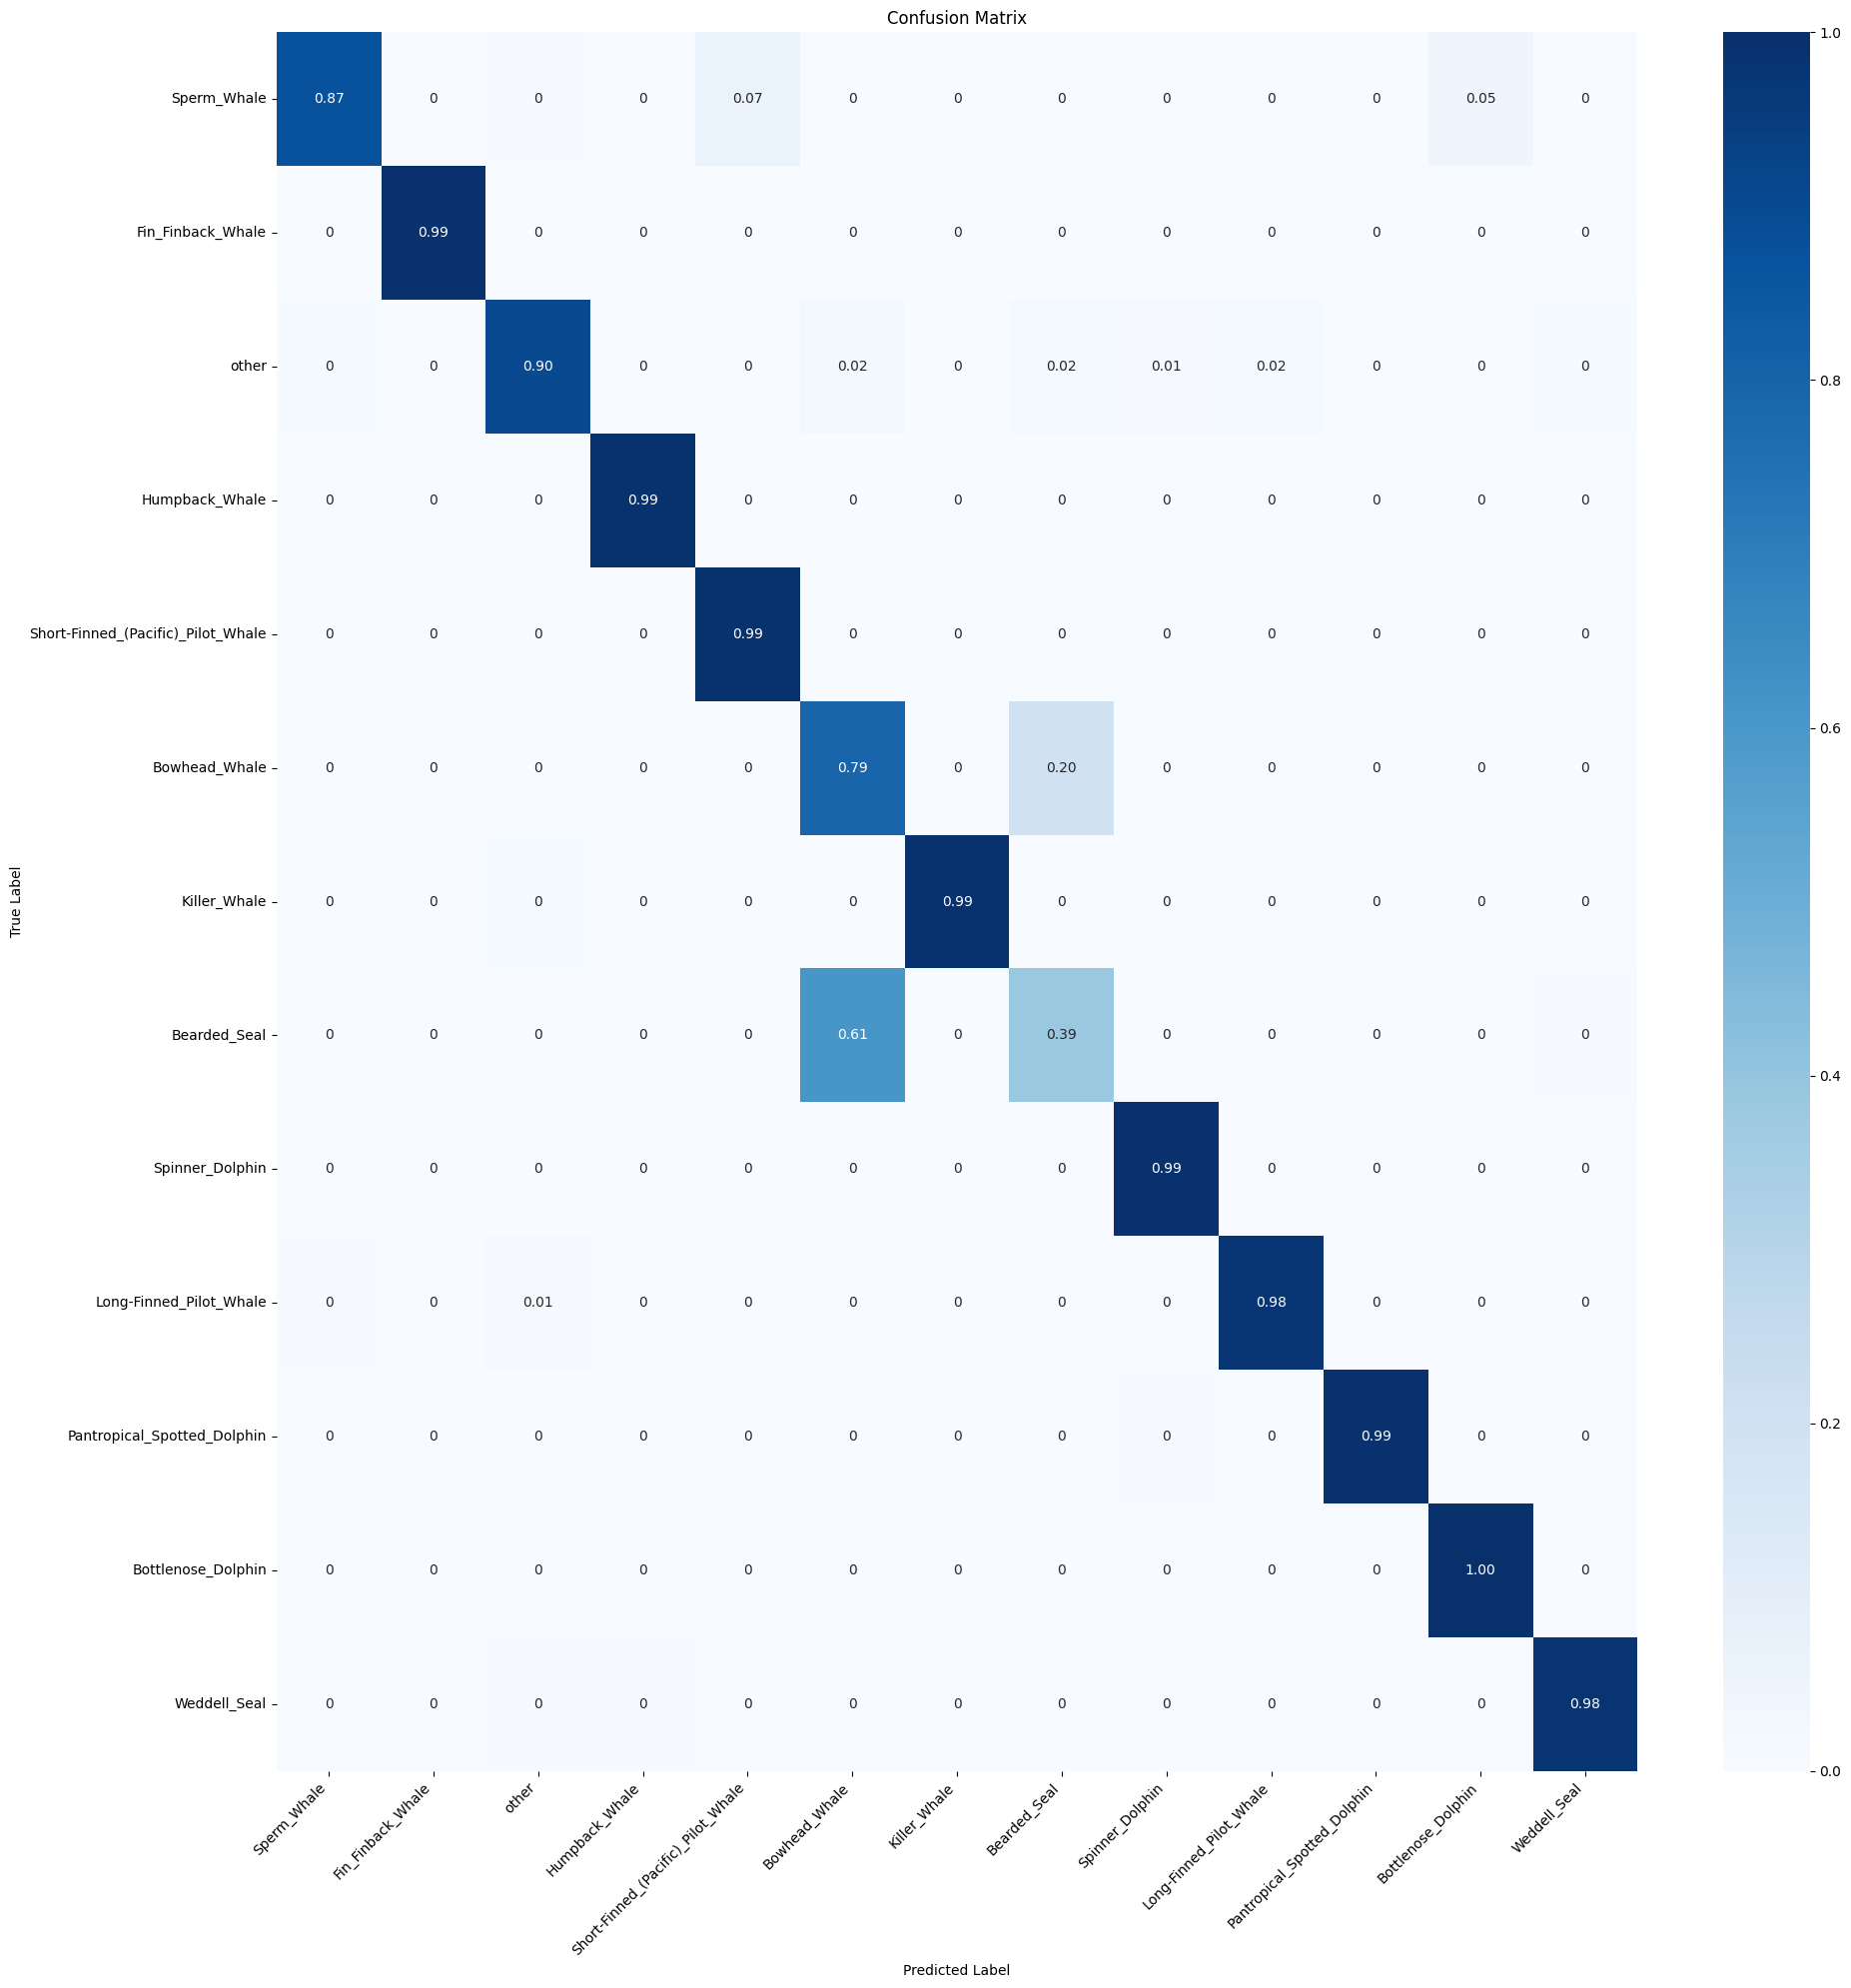

[[7435    1   48    0  595    0    2    0    5   23    8  388   22]
 [   0 2640   10    2    0    0    1    0    0    2    0    0    0]
 [  12    4 1374    2    1   36    1   28   21   28    0    0   12]
 [   1    0    2 1243    0    4    0    1    0    0    0    1    4]
 [   2    0    2    0  527    0    1    0    0    1    0    0    0]
 [   0    0    1    0    0  406    0  103    0    1    0    0    0]
 [   0    0    4    0    0    0  474    0    0    0    0    0    0]
 [   0    0    1    1    0  287    0  183    0    0    0    0    2]
 [   0    0    1    0    0    0    0    0  350    1    0    0    0]
 [   2    0    5    0    0    0    0    0    0  330    0    0    0]
 [   0    0    0    0    0    0    0    0    2    0  334    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  323    0]
 [   1    0    2    2    0    0    0    0    0    0    0    0  266]]


In [5]:
cnn_pred_df = pd.read_csv("cnn_predictions.csv")
num_classes = cnn_pred_df['index_label'].nunique()

y_pred = cnn_pred_df['CNN_predicted_index'].values
y_true = cnn_pred_df['index_label'].values
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
cm = cm.numpy()

cm_label = pd.read_csv(os.path.join(MODELS_METRICS_DIR, "label_to_index.csv"))
cm_label = cm_label.sort_values('index')
cm_label_list = cm_label['label'].values.tolist()[:num_classes]

confusion_matrix_plot(cm, cm_label_list)

print(cm)


In [6]:
proto_pred = pd.read_csv("proto_predictions.csv")

proto_pred['label'] = proto_pred.apply(lambda x: 'CNN_error' if x['other']==0 else x['label'], axis=1)
label_list = proto_pred['label'].unique().tolist()+proto_pred['proto_predicted_label'].unique().tolist()
label_list = list(set(label_list))
print(label_list)



['Striped_Dolphin', 'Gray_Whale', 'Irawaddy_Dolphin', 'Atlantic_Spotted_Dolphin', 'Tucuxi_Dolphin', 'Leopard_Seal', 'Narwhal', 'New_Zealand_Fur_Seal', 'Boutu_Amazon_River_Dolphin', 'Long_Beaked_(Pacific)_Common_Dolphin', 'Walrus', "Heaviside's_Dolphin", 'West_Indian_Manatee', 'Southern_Right_Whale', 'Melon_Headed_Whale', 'Harp_Seal', 'CNN_error', 'Finless_Porpoise', 'Northern_Right_Whale', 'White-beaked_Dolphin', "Fraser's_Dolphin", 'Hooded_Seal', 'White-sided_Dolphin', 'Ringed_Seal', 'Ribbon_Seal', 'Common_Dolphin', 'Sea_Otter', 'Beluga_White_Whale', "Grampus_Risso's_Dolphin", 'Dusky_Dolphin', 'Juan_Fernandez_Fur_Seal', "Dall's_Porpoise", 'Ross_Seal', 'Rough-Toothed_Dolphin', 'Clymene_Dolphin', 'Harbor_Porpoise', 'False_Killer_Whale', 'Spotted_Seal', 'Minke_Whale', 'Steller_Sea_Lion']


/home/elisa/FewShotLearning/ds_creation/plot_utility.py:168: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2625: RuntimeWarning: invalid value encountered in custom_format (vectorized)
  outputs = ufunc(*args, out=...)


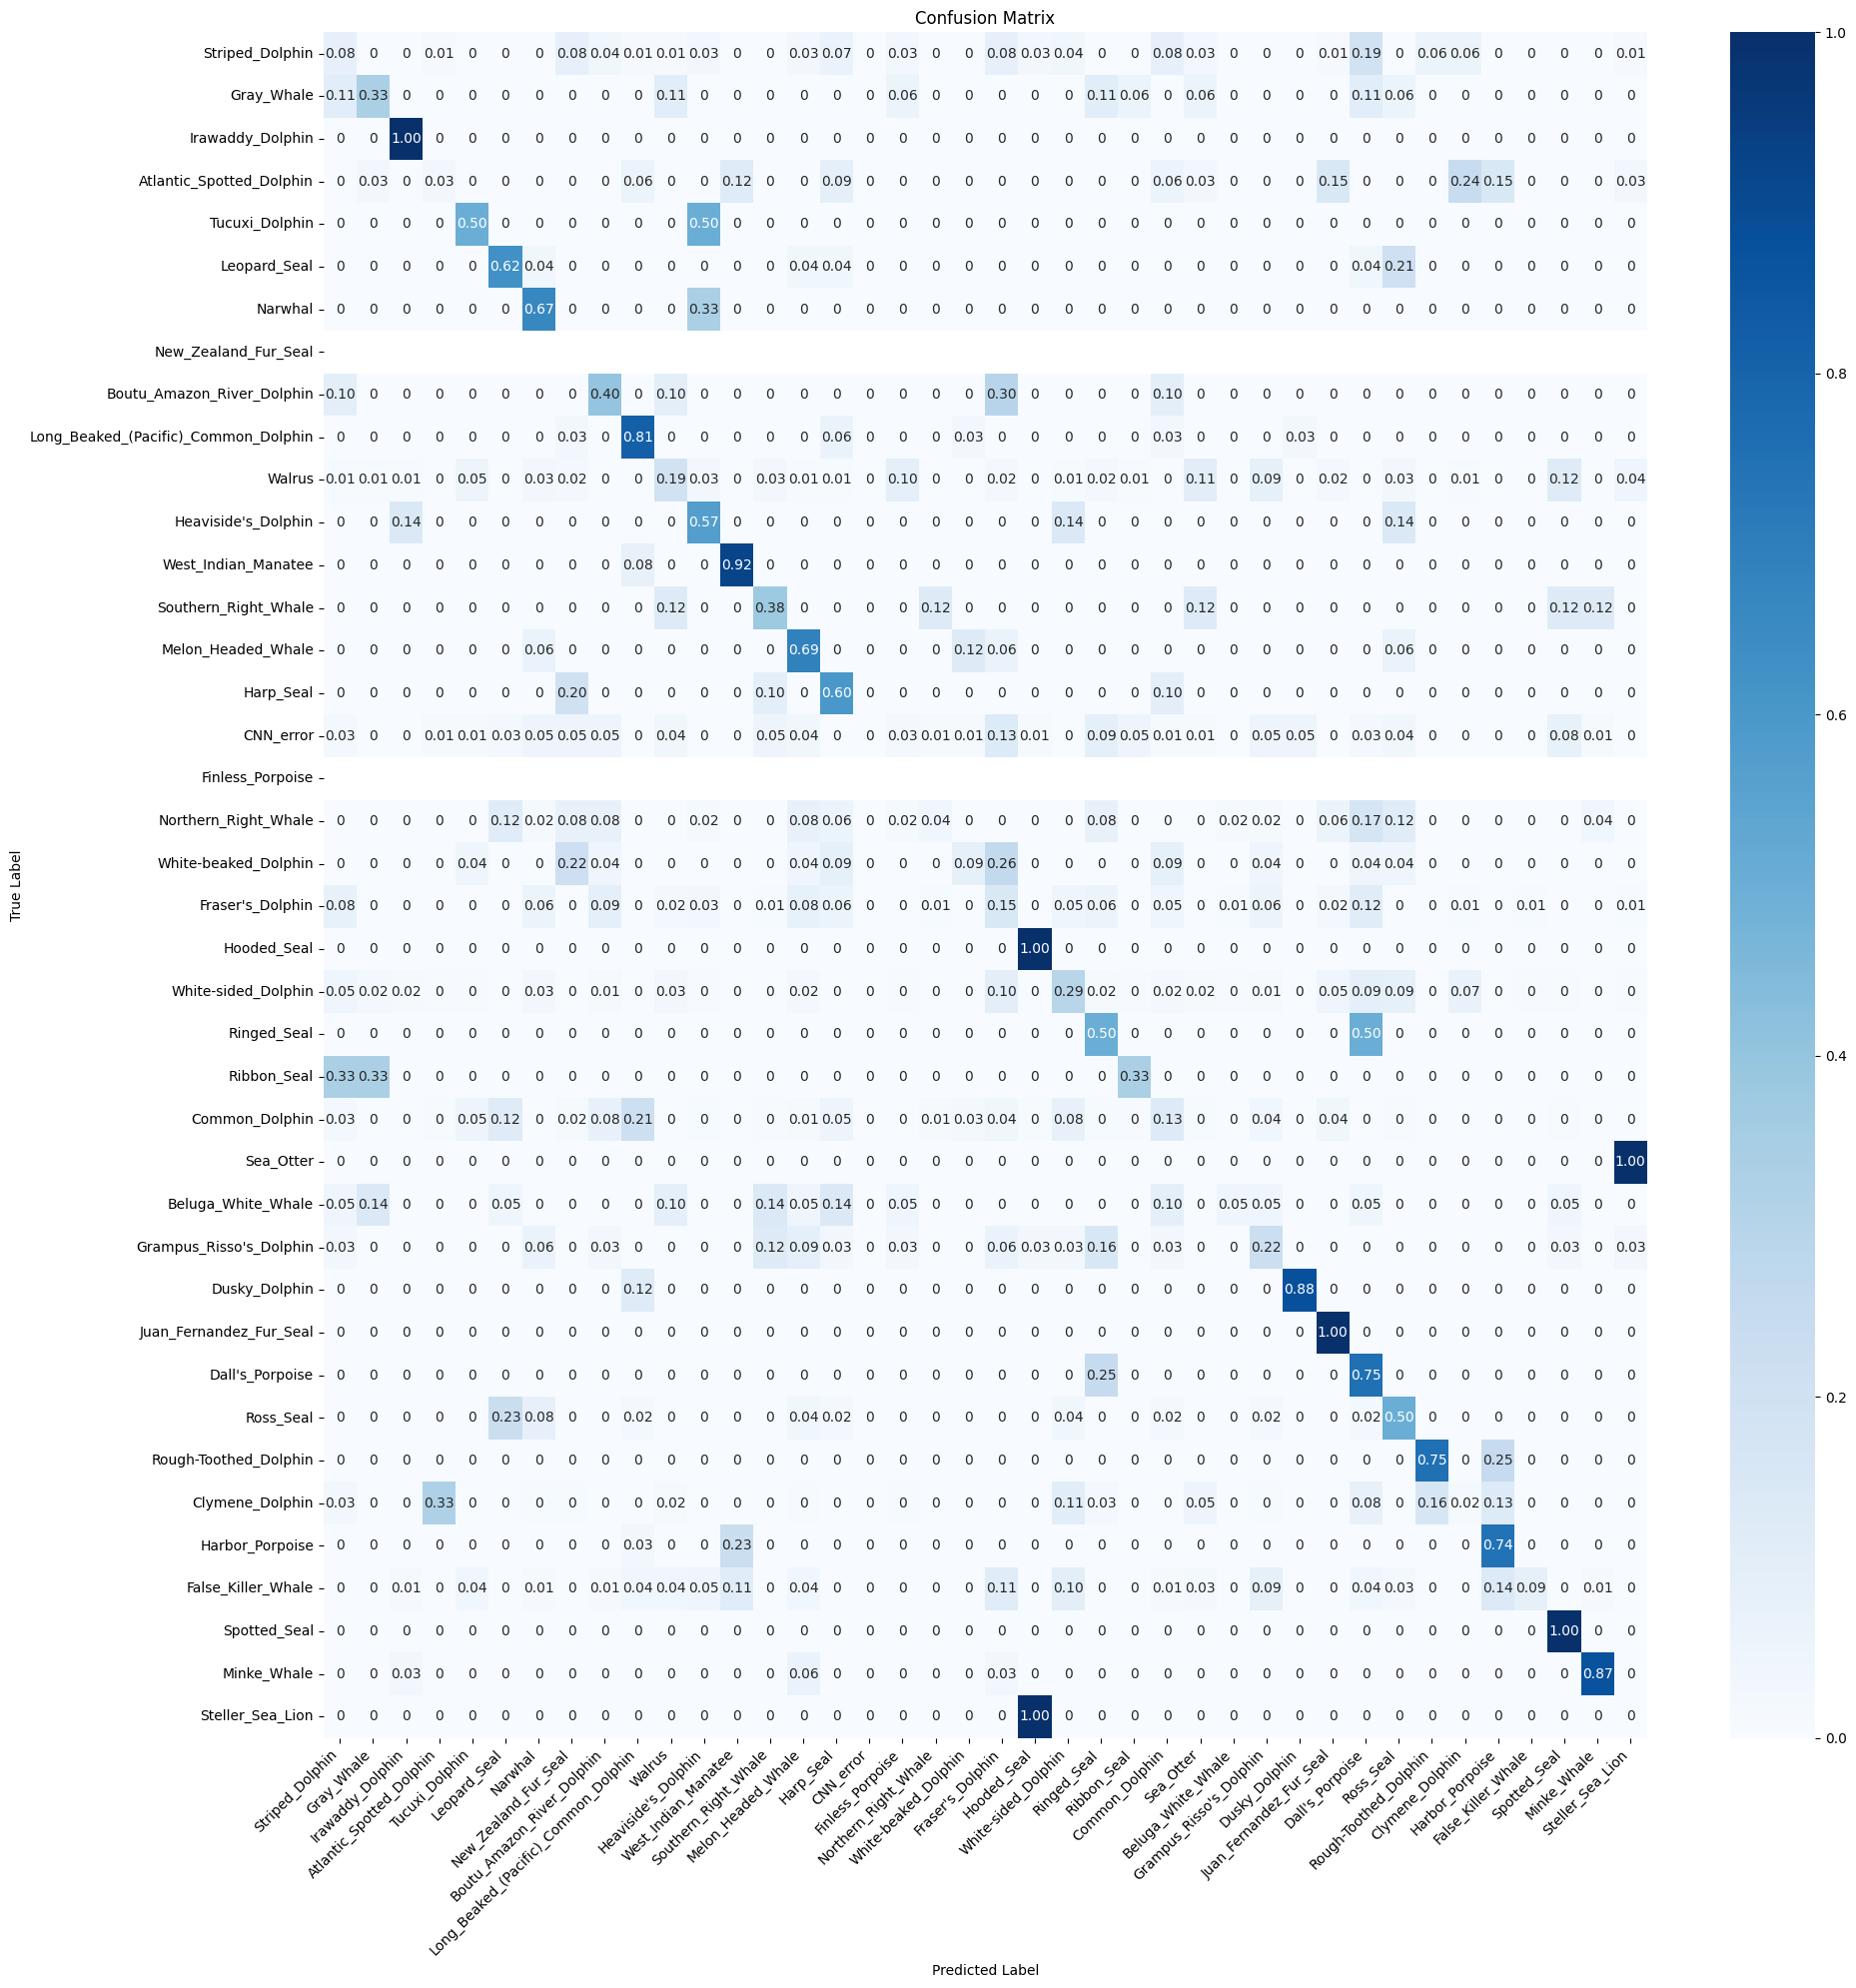

                                   class  correct_predictions  accuracy
21                           Hooded_Seal                    2  1.000000
12                   West_Indian_Manatee                   60  0.923077
29                         Dusky_Dolphin                   29  0.878788
9   Long_Beaked_(Pacific)_Common_Dolphin                   26  0.812500
38                           Minke_Whale                   27  0.794118
33                 Rough-Toothed_Dolphin                    3  0.750000
31                       Dall's_Porpoise                    3  0.750000
35                       Harbor_Porpoise                   26  0.742857
6                                Narwhal                    2  0.666667
11                   Heaviside's_Dolphin                    4  0.571429
30               Juan_Fernandez_Fur_Seal                    1  0.500000
37                          Spotted_Seal                    2  0.500000
4                         Tucuxi_Dolphin                    1  0

In [14]:
proto_mapping = {label:i for i, label in enumerate(label_list)}
proto_pred['index_label'] = proto_pred.apply(lambda x: proto_mapping[x['label']], axis=1)
proto_pred['proto_predicted_index'] = proto_pred.apply(lambda x: proto_mapping[x['proto_predicted_label']], axis=1)

y_pred = proto_pred['proto_predicted_index'].values
y_true = proto_pred['index_label'].values

cm = tf.math.confusion_matrix(y_true, y_pred,).numpy()
accuracy_dict = confusion_matrix_plot(cm, label_list)

accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['class', 'correct_predictions'])
accuracy_df['accuracy'] = accuracy_df.apply(lambda x: x['correct_predictions']/len(os.listdir(os.path.join(DATA_DIR, x['class']))) if x['class']!='CNN_error' else 0, axis=1)
accuracy_df = accuracy_df.sort_values('accuracy', ascending=False)
print(accuracy_df)
